In [1]:
import numpy as np
import matplotlib.pyplot as plt

# URA masks in 1D

See the last line:

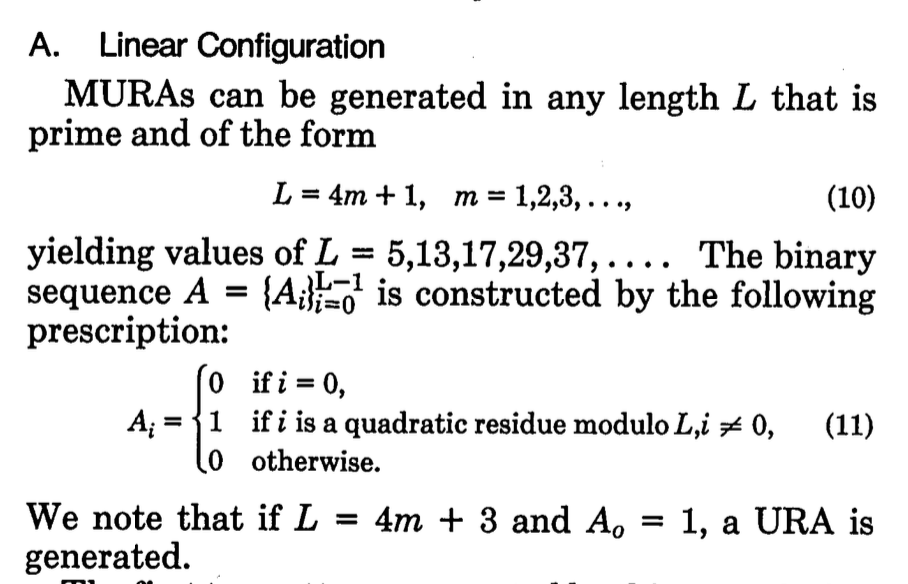

From wiki:

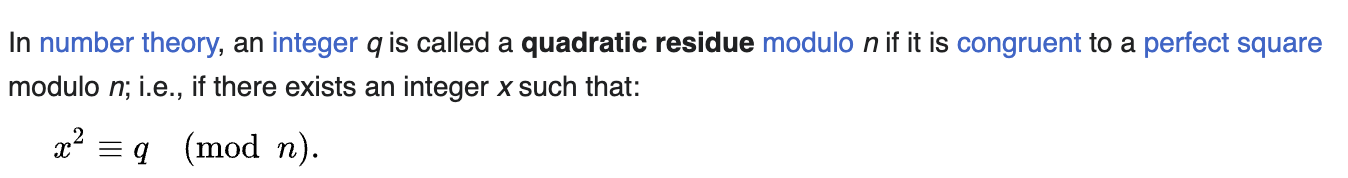

Let's consider the case $m = 1$

In [2]:
m = 1
L = 4*m + 3

The quadratic residue modulo L are:

In [3]:
np.mod(np.arange(L) ** 2, L)

array([0, 1, 4, 2, 2, 4, 1])

Hence all the following positions will be ones:

In [4]:
np.unique(np.mod(np.arange(L) ** 2, L))

array([0, 1, 2, 4])

Note that with python since `0 % n == 0` for all `n`, there is no need to explicitly set `A[0]` to `1`.

Putting it all together in a function:

In [5]:
from sympy.ntheory.primetest import isprime

def linear_ura(m):
    L = 4*m + 3
    assert(isprime(L))
    A = np.zeros(L)
    G = np.ones(L) # decoding
    A[np.unique(np.mod(np.arange(L) ** 2, L))] = 1
    G[A == 0] = -1
    return A, G

In [6]:
A, G = linear_ura(1)
A, G

(array([1., 1., 1., 0., 1., 0., 0.]),
 array([ 1.,  1.,  1., -1.,  1., -1., -1.]))

Which is the mask of Gottesman 2007.

Let's see if the function is ok checking the autocorrelation for multiple `m`s.

In [7]:
from scipy.linalg import hankel

def pad(A):
    n = int(len(A)/2)
    return np.concatenate((A[-n:], A, A[:n]))

def autocorr(A, G):
    assert(len(A) == len(G))
    A_, G_ = pad(A), pad(G)
    n = len(A)
    hankel_ura_mask = hankel(A_[:n], A_[n - 1:])
    hankel_decoding = hankel(G_[:n], G_[n - 1:])
    return np.dot(hankel_ura_mask, hankel_decoding)

In [8]:
autocorr(*linear_ura(1))

array([[4., 0., 0., 0., 0., 0., 0.],
       [0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 4., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0.],
       [0., 0., 0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 0., 0., 4.]])

In [9]:
for n in range(1, 67):
    if not isprime(4*n + 3):
        continue
    corr = autocorr(*linear_ura(n))
    assert(np.array_equal(corr, corr[0][0] * np.diag(np.ones(4*n + 3))))
print(f"all correlations up to n={n} are deltas")

all correlations up to n=66 are deltas


# URA masks in 2D

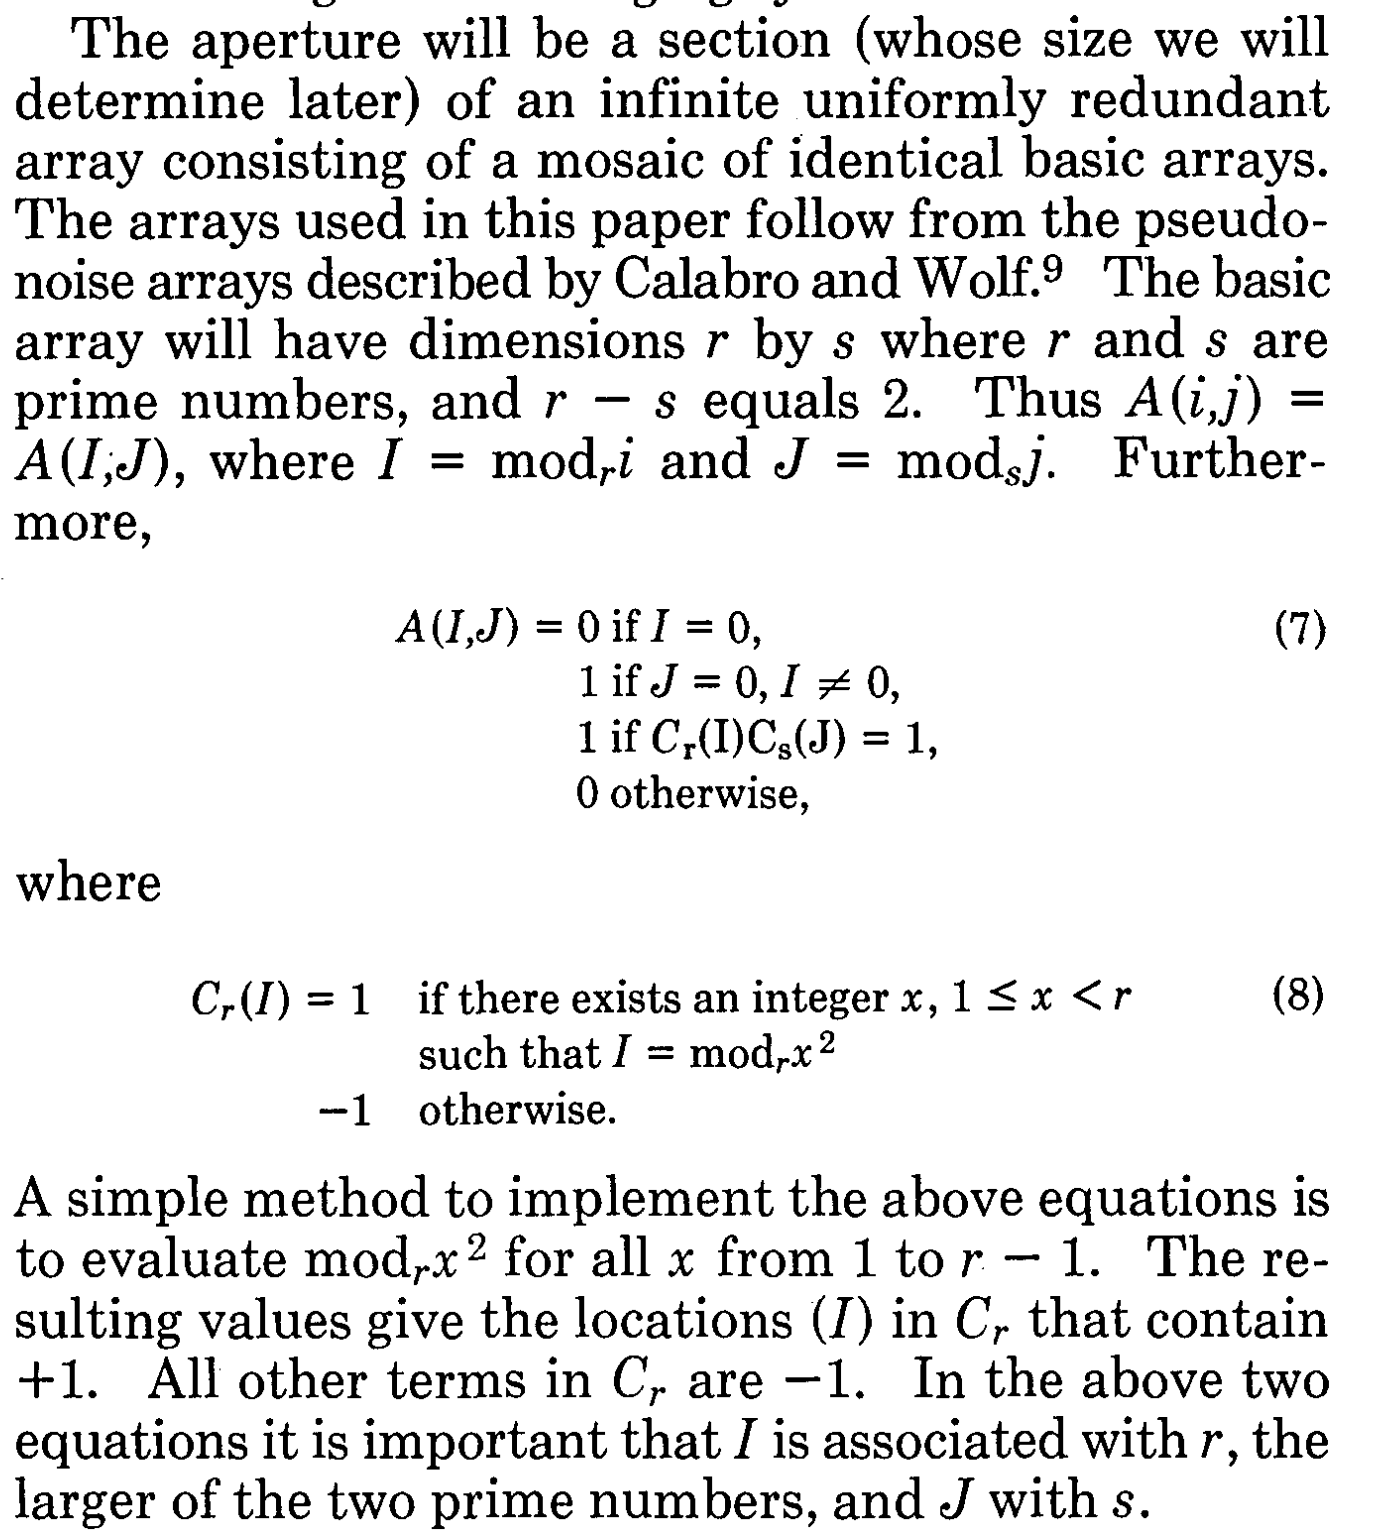

An implementation of URA masks is available at this [repo](https://github.com/bpops/codedapertures). Here it is:

In [10]:
def ura(r, s, m=1):
    assert(isprime(r))
    assert(r - s == 2)
    
    C_r_I = np.zeros(r) - 1
    C_s_J = np.zeros(s) - 1
    for x in range(1, r):
        C_r_I[x**2 % r] = 1
    for y in range(1, s):
        C_s_J[y**2 % s] = 1

    A_IJ = np.zeros([r,s])
    for I in range(r):
        for J in range(s):
            if I == 0:
                A_IJ[I,J] = 0
            elif J == 0:
                A_IJ[I,J] = 1
            elif C_r_I[I] * C_s_J[J] == 1:
                A_IJ[I,J] = 1

    A_ij = np.zeros([m*r,m*s])
    for i in range(m*r):
        for j in range(m*s):
            A_ij[i,j] = A_IJ[i%r,j%s]
    A_ij = np.roll(A_ij, int((r+1)/2), axis=0)
    A_ij = np.roll(A_ij, int((s+1)/2), axis=1)
    return A_ij